# Data Analysis

Now that our data is clean and ready, lets give it a closer look.

In this section, we will cover:

- analysis of sample distribution
- balancing the data



In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import aux_functions as aux

In [2]:
# loading the data and testing our script
df_old = pd.read_csv('df_transformed.csv')
df = pd.read_csv('data/Auto1-DS-TestData.csv')
df = aux.clean_data(df)

for col_type in ['object', 'int64', 'float64']:
    test = (df.select_dtypes(col_type).describe() != df_old.select_dtypes(col_type).describe())
    if test.any().sum():
        print('not equal on ', col_type)
    else:
        print('all ok with', col_type)

all ok with object
all ok with int64
all ok with float64


## Analysis of sample distribution

Before splitting train and test, let's look out how balanced the data is:


In [3]:
df.price.describe()

count      193.000000
mean     13285.025907
std       8089.082886
min       5118.000000
25%       7738.000000
50%      10245.000000
75%      16515.000000
max      45400.000000
Name: price, dtype: float64

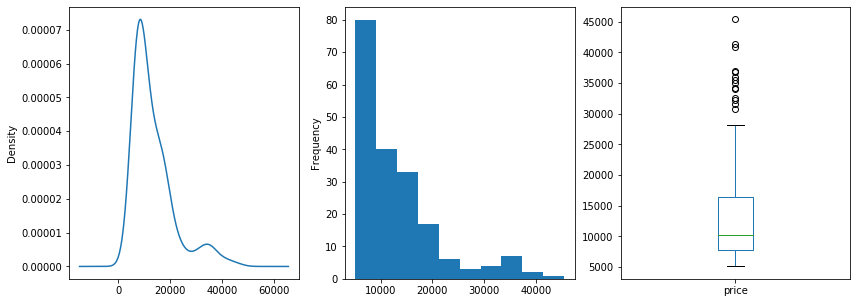

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax, ax2, ax3) = plt.subplots(ncols=3, sharey=False)

figsize = (14, 5)
df.price.plot(kind='kde', legend=False, ax=ax,  figsize=figsize)
df.price.plot(kind='hist',ax=ax2, figsize=figsize)
df.price.plot(kind='box', legend=False, ax=ax3, figsize=figsize)
plt.show()

From the density plot, it looks like our data follows a *bimodal distribution*.

In [5]:
top_wisker = df.price.quantile(.75) + 1.5*(df.price.quantile(.75) - df.price.quantile(.25))
print(f'Wisker upper: {top_wisker}')

# prob for y > top_wisker
import scipy.stats as st
prob = 1 - st.norm.cdf(top_wisker, df.price.mean(), df.price.std())
print(f'prob for y > top_wisker: {prob:.3}')
      
#99% quantile
qt = st.norm.ppf(.99, df.price.mean(), df.price.std()) # just exploring
print(f'99% quantile: {qt:4.3}')
      
# prob for prices bellow 32k
prob = st.norm.cdf(32000, df.price.mean(), df.price.std()) # just exploring
print(f'prob for prices bellow 32k: {prob:.3}')

Wisker upper: 29680.5
prob for y > top_wisker: 0.0213
99% quantile: 3.21e+04
prob for prices bellow 32k: 0.99


### Splitting cars in classes according to its price

Just to take a look into the distribution of prices and into the samples available for each price range, lets define car classes according to price ranges:

In [6]:
labels = [
    'almost-free', 'super-cheap', 'cheap',
    'normal', 'expensive', 'super-expensive'
]
df["class_range"] = pd.cut(df.price, 6, labels=labels)
df[['class_range', 'price']].sample(10)

,class_range,price
113,super-cheap,16695.0
181,super-cheap,15750.0
107,super-cheap,11900.0
93,almost-free,7349.0
47,expensive,32250.0
67,normal,25552.0
65,super-cheap,18280.0
4,super-cheap,17450.0
127,expensive,34028.0
154,almost-free,7898.0


In [7]:
df.groupby('class_range')[['price']].min() # starting prices for each class

,price
class_range,
almost-free,5118.0
super-cheap,11850.0
cheap,18620.0
normal,25552.0
expensive,32250.0
super-expensive,40960.0


In [8]:
df.class_range.value_counts()

almost-free        110
super-cheap         53
cheap               13
expensive            9
normal               5
super-expensive      3
Name: class_range, dtype: int64

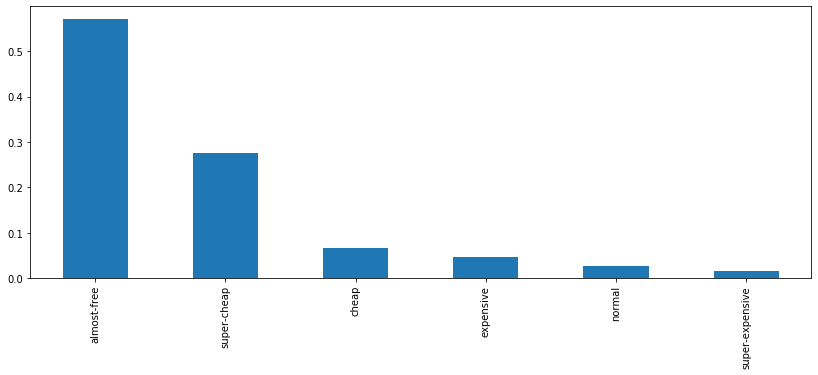

In [9]:
df.class_range.value_counts(normalize=True).plot.bar(figsize=figsize)

From this brief analysis about prices, we found that:
- the distribution is not normal - could be bimodal as well
- there is no balance on price ranges, therefore we must take precautions when splitting the train/test sets
- a log transformation on prices would be useful for linear models, since it makes the transformed prices fall into a normal distribution

## Log transformation on prices

Due to the present of outliers, the spread of distribution and because the prices don't follow a normal distribution, regular linear models will have some trouble predicting prices. 

Among the problems that can occur:

- outliers can be highly influent and thus can leverage and disturb the fitting
- negative prediction for prices can happen

Therefore, models which uses L1 penalization will perform better.
Among them are lasso, huber and ElasticNet.

On the other hand, other linear models can be used if we use a log transformation on prices, so their distribution becomes normal:

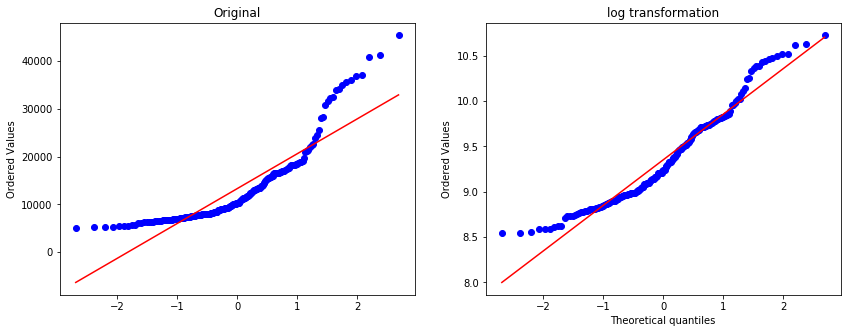

In [10]:
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax, ax1) = plt.subplots(ncols=2, sharey=False, figsize=figsize)

prob = stats.probplot(df.price, dist=stats.norm, plot=ax)
ax.set_xlabel('')
ax.set_title('Original')

log_price = np.log(df.price)
prob = stats.probplot(log_price, dist=stats.norm, plot=ax1)
ax1.set_title('log transformation')

plt.show()

## Discussion about outliers

There are data points which are outside of the expected range of the normal distribution of prices and therefore could be outliers.

This happens either because they really are outliers or because this is not a normal distribution.

We must test those data points because if they are real outliers, there is a change they could be influential points which are going to leverage the model.

Lets see about that later.

## Balancing the data: bootstrap

Our dataset has only 197 records and some classes are not well represented here.
We will fix this balance issue through bootstrap: lets make our data grown by random sampling it:


In [11]:
df_old = df.copy()
df = df.sample(10000, replace=True)
df.shape

(10000, 26)

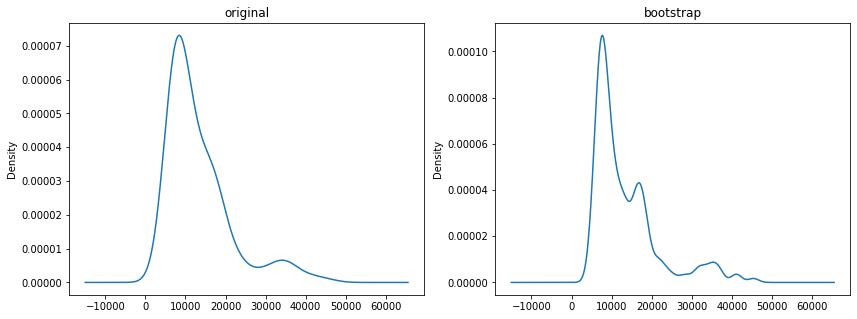

In [12]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=figsize)

df_old.price.plot(kind='kde', legend=False, ax=ax, title="original")
df.price.plot(kind='kde',ax=ax2, title="bootstrap")
plt.show()

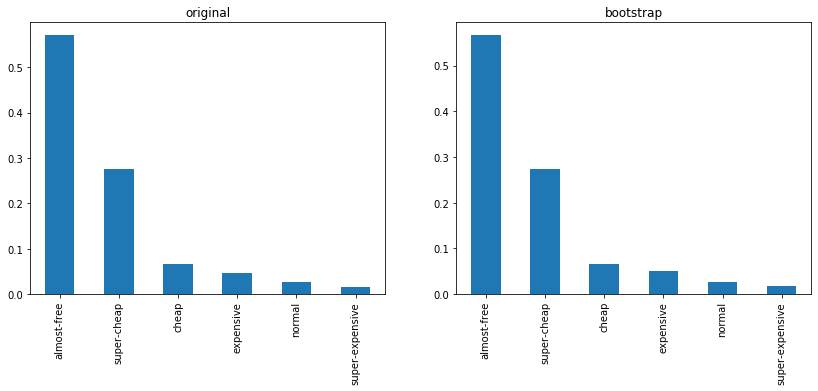

In [13]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=figsize)
df_old.class_range.value_counts(normalize=True).plot.bar(ax=ax, title='original')
df.class_range.value_counts(normalize=True).plot.bar(ax=ax2, title='bootstrap')

In [14]:
print(
    'original\n',
    df.class_range.value_counts(normalize=True),
    '\n#########\n',
    'bootstrap\n',
    df_old.class_range.value_counts(normalize=True)
)

original
 almost-free        0.5662
super-cheap        0.2736
cheap              0.0669
expensive          0.0500
normal             0.0260
super-expensive    0.0173
Name: class_range, dtype: float64 
#########
 bootstrap
 almost-free        0.569948
super-cheap        0.274611
cheap              0.067358
expensive          0.046632
normal             0.025907
super-expensive    0.015544
Name: class_range, dtype: float64


In [15]:
df.drop('class_range', axis=1).to_csv('df_resample.csv', index=False)